# WM-811k Preprocessing

This notebook contains the preprocessing steps for the WM-811k dataset. The dataset is available at http://mirlab.org/dataset/public/, and we walk through the steps to download and preprocess the dataset to create the aggregated dataset used in the paper.

In [ ]:
# !pip install --upgrade lightning timm pandas opencv-contrib-python --quiet

## Imports

In [1]:
import os
import warnings
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import timm
import torch
import torchvision.transforms as T
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", ".*does not have many workers.*")
if not torch.cuda.is_available():
    print("If on colab, switch to GPU runtime: Runtime -> Change runtime type -> GPU")

If on colab, switch to GPU runtime: Runtime -> Change runtime type -> GPU


## Data Preprocessing

This section goes over how the data is initially downloaded and preprocessed.

In [2]:
# Create directory for data
save_path = "../data/raw"
os.makedirs(save_path, exist_ok=True)

# Download the zip file from url, and extract contents to save_path
url = "http://mirlab.org/dataset/public/MIR-WM811K.zip"
# Proceed only if the data has not been downloaded yet
if not os.path.exists(os.path.join(save_path, "MIR-WM811K")):
    with urlopen(url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(save_path)
else:
    print("Data already downloaded.")

Data already downloaded.


In [3]:
path = f"{save_path}/MIR-WM811K/Python/WM811K.pkl"
df = pd.read_pickle(path)
df

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
811452,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811453,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."
811454,600.0,Edge-Ring,lot47542,Test,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,"[0, 0]",lot47543,"[0, 0]",1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."


In [4]:
# [0, 0] is unhashable in failureType and trainTestLabel --> replace with "unlabeled"
# Use pd.api.types.is_array_like to check if a value is array-like
df.loc[df.failureType.apply(pd.api.types.is_array_like), "failureType"] = "unlabeled"
df.loc[df.trainTestLabel.apply(pd.api.types.is_array_like), "trainTestLabel"] = "unlabeled"
df

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
811452,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811453,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."
811454,600.0,Edge-Ring,lot47542,Test,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,unlabeled,lot47543,unlabeled,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."


The distribution of failure type categories is heavily skewed. Moreover, the distributions of the `"Training"` and `"Test"` datasets isn't even the same! Both datasets have far more "none"-type failure shadings than the other types (which is typical of qualified semiconductor products going through high-volume manufacturing). However, the `"Test"` dataset's "none"-type shadings dwarfs the other failure shadings entirely.

,count,fraction
failureType,,
none,36730,0.675743
Edge-Ring,8554,0.157373
Center,3462,0.063692
Edge-Loc,2417,0.044467
Loc,1620,0.029804
Random,609,0.011204
Scratch,500,0.009199
Donut,409,0.007525
Near-full,54,0.000993


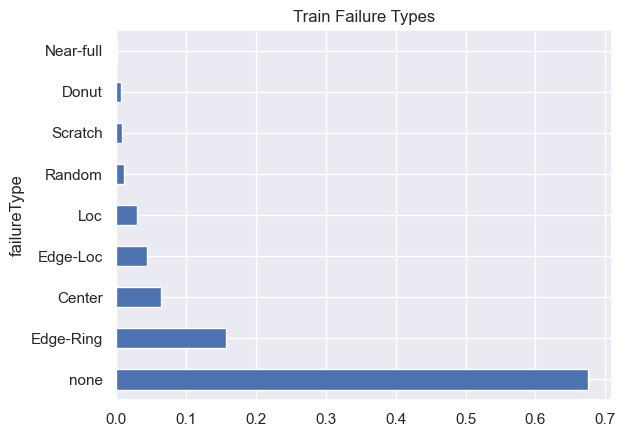

,count,fraction
failureType,,
none,110701,0.933437
Edge-Loc,2772,0.023374
Loc,1973,0.016636
Edge-Ring,1126,0.009494
Center,832,0.007015
Scratch,693,0.005843
Random,257,0.002167
Donut,146,0.001231
Near-full,95,0.000801


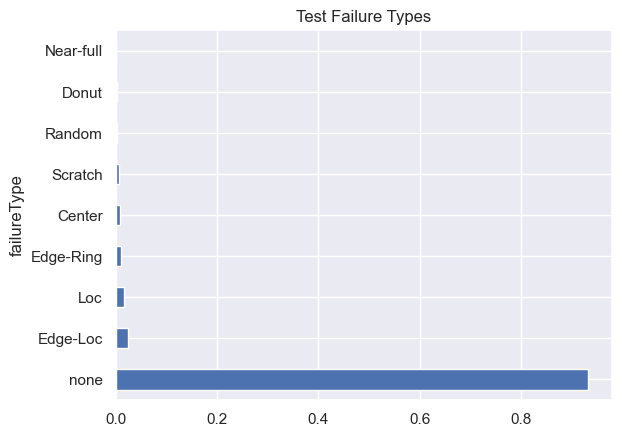

In [5]:
sns.set_theme()

def show_breakdown(series, title=None):
    """
    Given a pandas Series, displays value_counts(), both raw counts and normalized.
    Also plots a horizontal bar chart of normalized value counts.
    """
    breakdown = pd.concat(
        [series.value_counts(), series.value_counts(normalize=True)],
        axis=1,
        keys=("count", "fraction")
    )
    display(breakdown)
    breakdown.fraction.plot(kind="barh")
    if title:
        plt.title(title)
    plt.show()


train_shadings = df.loc[df.trainTestLabel == "Training"].failureType
test_shadings = df.loc[df.trainTestLabel == "Test"].failureType

show_breakdown(train_shadings, title="Train Failure Types")
show_breakdown(test_shadings, title="Test Failure Types")

We've come across papers that choose to ignore this `"Test"` dataset entirely and create custom training and test datasets from the `"Training"` subset alone. This is usually done to ensure that the data can be split in a stratified fashion. We follow a similar approach here, but rather than throwing out the `"Test"` dataset entirely, we keep all non-"none"-type failure shadings from that datasets. Concretely, we create an aggregate dataset that has all of the `"Training"` subset, and everything in `"Test"` where `failureType != "none"`.

In [6]:
# Get rid of everything unlabeled, then we want everything that isn't a Test + none-failureType
idx = (df.trainTestLabel == "unlabeled") | (
    (df.trainTestLabel == "Test") & (df.failureType == "none")
)
data = df.loc[~idx].reset_index(drop=True)
data

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
62244,600.0,Edge-Loc,lot47542,Test,21.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,..."
62245,600.0,Edge-Loc,lot47542,Test,22.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."
62246,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
62247,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."


Because I've worked with this data once before, I know that there's a single data point here that is not a real wafermap (it's probably just a slice of one). Its waferMap is just 3 columns long, and not even close to a square.

In [7]:
bad_idx = data.waferMap.apply(lambda x: np.size(x)).argmin()
print(bad_idx)
# Show the problematic wafermap
data.waferMap.iloc[bad_idx]

46155


array([[0, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [8]:
# Drop the bad row and reset the indices
data.drop(index=bad_idx, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...
62243,600.0,Edge-Loc,lot47542,Test,21.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,..."
62244,600.0,Edge-Loc,lot47542,Test,22.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."
62245,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
62246,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."


For compatibility with image processing libraries, the domain of our NumPy arrays will need to be scaled to an RGB domain. We'll also want a column with category codes (integers) instead of the failure types (strings).

In [9]:
# Modified from https://github.com/sparks-baird/xtal2png/blob/main/src/xtal2png/utils/data.py#L138
def rgb_scale(
    X, feature_range=[0, 255], data_range=None,
):
    """Scales array to RGB domain [0, 255]
    """
    import numpy as np
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if data_range is None:
        data_range = [np.min(X), np.max(X)]
    if feature_range is None:
        feature_range = [np.min(X), np.max(X)]

    data_min, data_max = data_range
    feature_min, feature_max = feature_range
    X_std = (X - data_min) / (data_max - data_min)
    X_scaled = X_std * (feature_max - feature_min) + feature_min
    X_scaled = np.round(X_scaled).astype(np.uint8)
    return X_scaled


data.waferMap = data.waferMap.apply(rgb_scale)
# Create a failureCode column that is the categorical code of failureType
data["failureCode"] = data.failureType.astype("category").cat.codes
data

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,failureCode
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
...,...,...,...,...,...,...,...
62243,600.0,Edge-Loc,lot47542,Test,21.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 1...",2
62244,600.0,Edge-Loc,lot47542,Test,22.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128, 1...",2
62245,600.0,Edge-Ring,lot47542,Test,23.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 1...",3
62246,600.0,Edge-Loc,lot47542,Test,24.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 1...",2


With this cleaned and aggregated data, we can create our own train and test splits, stratifying them according to the failure types. Below, we split the aggregate data into an 80/20 trainval/test split, and we verify that the distributions of failure categories across our splits are the same thanks to stratified splitting.

,count,fraction
failureType,,
none,29383,0.590044
Edge-Ring,7744,0.155508
Edge-Loc,4151,0.083357
Center,3435,0.068979
Loc,2874,0.057713
Scratch,955,0.019177
Random,693,0.013916
Donut,444,0.008916
Near-full,119,0.002390


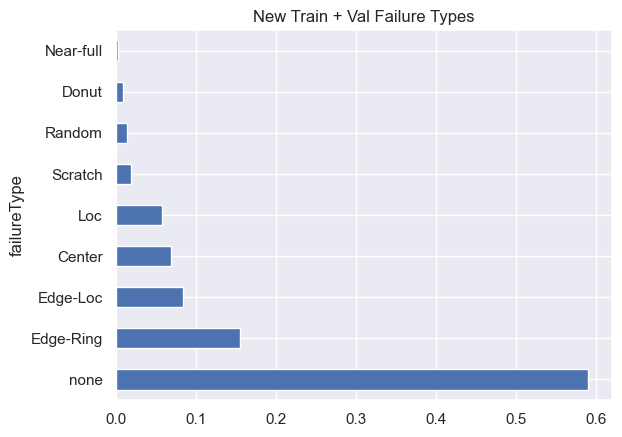

,count,fraction
failureType,,
none,7346,0.590040
Edge-Ring,1936,0.155502
Edge-Loc,1038,0.083373
Center,859,0.068996
Loc,719,0.057751
Scratch,238,0.019116
Random,173,0.013896
Donut,111,0.008916
Near-full,30,0.002410


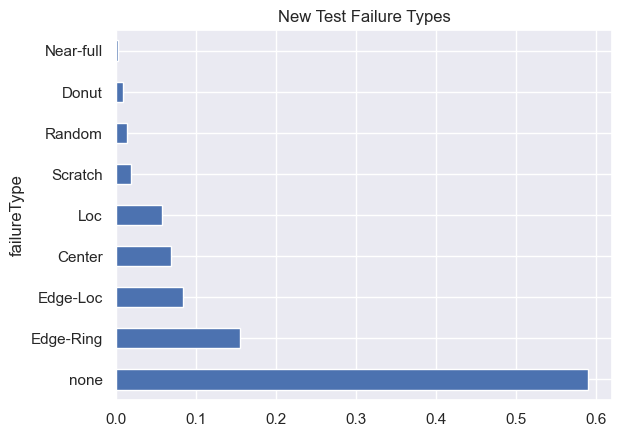

In [10]:
# Select only the waferMap and failureCode/Type columns
data = data[["waferMap", "failureType", "failureCode"]]

train_val_data, test_data = train_test_split(
    data, test_size=0.2, stratify=data.failureType, random_state=0
)
show_breakdown(train_val_data.failureType, title="New Train + Val Failure Types")
show_breakdown(test_data.failureType, title="New Test Failure Types")

Now, we'll create further splits of our data for the purpose of fine-tuning and comparing against fully supervised baselines. These splits will come from the train + val data. Recall we created an 80/20 split for `train_val_data` and `test_data`. This `train_val_data` will be broken down into a validation set and multiple subsets for finetuning: one with 1\% of the training labels, another 10\%, another with 20\%, and the last will have the 29\% leftover. First, we create the `val_data` and initial `train_data` below:

In [11]:
# Make val_data 20% of the full dataset like test_data by doing 0.25 * 80%
train_data, val_data = train_test_split(
    train_val_data, test_size=0.25, stratify=train_val_data.failureType, random_state=0
)
# train_split is now 0.75 * 80 = 60% of original dataset (60% of all labels)
display(train_data)
display(val_data)

,waferMap,failureType,failureCode
53885,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 128,...",none,8
41170,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...",none,8
32829,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...",none,8
52860,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128, 128,...",none,8
13414,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3
...,...,...,...
55641,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...",Loc,4
51722,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 128,...",none,8
58887,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12...",none,8
37900,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128...",none,8


,waferMap,failureType,failureCode
23933,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ...",Edge-Ring,3
27571,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...",Edge-Loc,2
54216,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...",none,8
6419,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
6697,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
...,...,...,...
57145,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4
56854,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
19726,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3
45974,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255,...",none,8


Now we use the `train_data` to create further splits for finetuning. Below this, we've included an icicle plot that visualizes the splits and their parent splits from the data to make things a bit more intuitive.

In [12]:
# Grab a 1% split from the 60% remaining data
train_59_split, train_1_split = train_test_split(
    train_data, test_size=1 / 60, stratify=train_data.failureType, random_state=0
)
# Grab a 10% split from the 59% remaining data
train_49_split, train_10_split = train_test_split(
    train_59_split,
    test_size=10 / 59,
    stratify=train_59_split.failureType,
    random_state=0,
)
# Grab a 20% split from the 49% remaining data
train_29_split, train_20_split = train_test_split(
    train_49_split,
    test_size=20 / 49,
    stratify=train_49_split.failureType,
    random_state=0,
)
# Sanity checks for fraction of data in each split
print(f"0.01 split {len(train_1_split) / (len(data)):.5f}")
print(f"0.10 split {len(train_10_split) / (len(data)):.5f}")
print(f"0.20 split {len(train_20_split) / (len(data)):.5f}")
print(f"0.29 split {len(train_29_split) / (len(data)):.5f}")
print(f"0.49 split {len(train_49_split) / (len(data)):.5f}")
print(f"0.59 split {len(train_59_split) / (len(data)):.5f}")
print(f"train data {len(train_data) / (len(data)):.5f}")
print(f"val data {len(val_data) / (len(data)):.5f}")
print(f"test data {len(test_data) / (len(data)):.5f}")

0.01 split 0.01001
0.10 split 0.10000
0.20 split 0.19999
0.29 split 0.28999
0.49 split 0.48998
0.59 split 0.58998
train data 0.59999
val data 0.20001
test data 0.20001


The icicle plot below shows the splits we've created. For this project, we'll be dealing with the 20\% split `train_20_split` which corresponds to about 12,000 examples.

In [13]:
import plotly.graph_objects as go

# Make an icicle plot for our paper showing breakdown of data
fig = go.Figure(
    go.Icicle(
        labels=[
            "Full Data (100)",

            "Test Data (20)",
            "Val Data (20)",
            "Train Data (60)",

            "20% Train Finetune",
            "10% Train Finetune",
            "1% Train Finetune",
            "Remainder (29)",
        ],
        parents=[
            "",

            "Full Data (100)",
            "Full Data (100)",
            "Full Data (100)",

            "Train Data (60)",
            "Train Data (60)",
            "Train Data (60)",
            "Train Data (60)",
        ],
        values = [
            len(data),

            len(test_data),
            len(val_data),
            len(train_data),

            len(train_20_split),
            len(train_10_split),
            len(train_1_split),
            len(train_29_split)
            
        ],
        branchvalues="total",
        root_color="lightgrey"
    )
)

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

Note that because we've done stratified splits, the breakdowns of failure categories in each split is ***the same***! As a sanity check, we show that the distributions of categories are exactly the same across all our new splits `train_1_split`, `train_10_split`, `train_20_split`, `train_29_split`, `train_data` and `val_data`

623


,count,fraction
failureType,,
none,368,0.590690
Edge-Ring,97,0.155698
Edge-Loc,52,0.083467
Center,43,0.069021
Loc,36,0.057785
Scratch,12,0.019262
Random,9,0.014446
Donut,5,0.008026
Near-full,1,0.001605


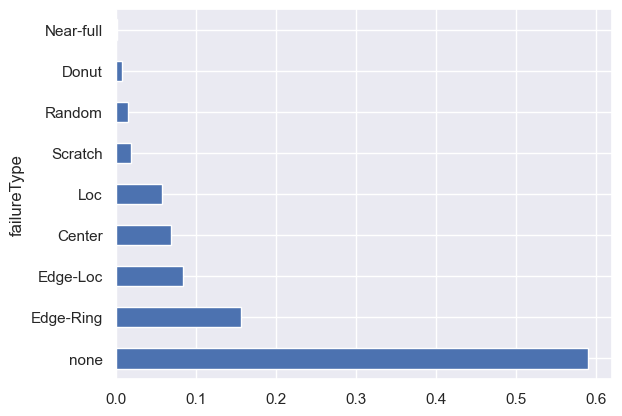

6225


,count,fraction
failureType,,
none,3673,0.590040
Edge-Ring,968,0.155502
Edge-Loc,519,0.083373
Center,429,0.068916
Loc,359,0.057671
Scratch,119,0.019116
Random,87,0.013976
Donut,56,0.008996
Near-full,15,0.002410


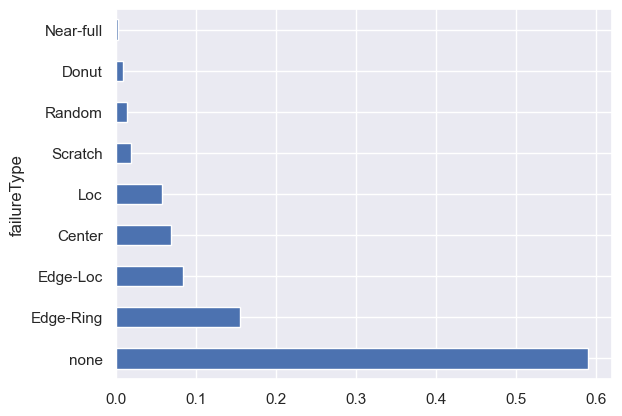

12449


,count,fraction
failureType,,
none,7345,0.590007
Edge-Ring,1936,0.155514
Edge-Loc,1037,0.083300
Center,859,0.069002
Loc,719,0.057756
Scratch,239,0.019198
Random,173,0.013897
Donut,111,0.008916
Near-full,30,0.002410


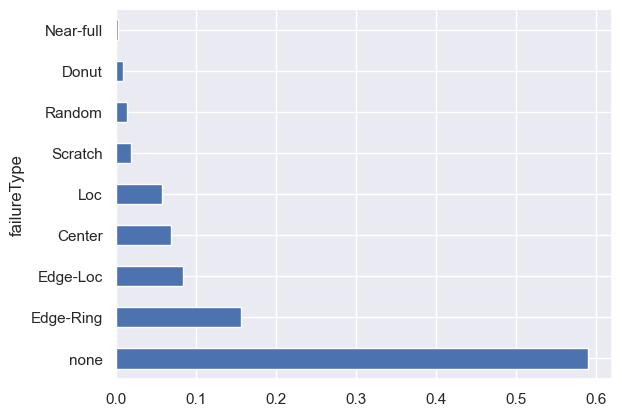

18051


,count,fraction
failureType,,
none,10651,0.590050
Edge-Ring,2807,0.155504
Edge-Loc,1505,0.083375
Center,1245,0.068971
Loc,1042,0.057725
Scratch,346,0.019168
Random,251,0.013905
Donut,161,0.008919
Near-full,43,0.002382


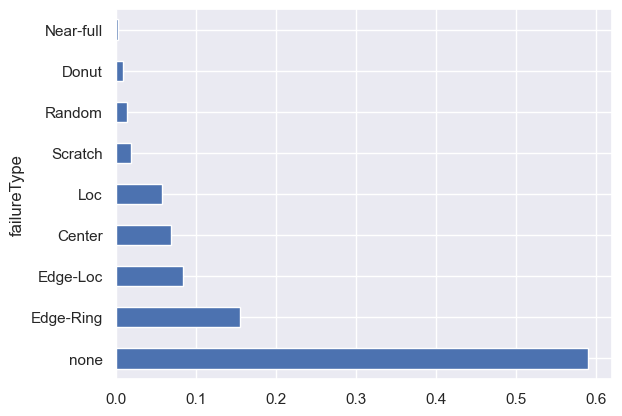

37348


,count,fraction
failureType,,
none,22037,0.590045
Edge-Ring,5808,0.155510
Edge-Loc,3113,0.083351
Center,2576,0.068973
Loc,2156,0.057727
Scratch,716,0.019171
Random,520,0.013923
Donut,333,0.008916
Near-full,89,0.002383


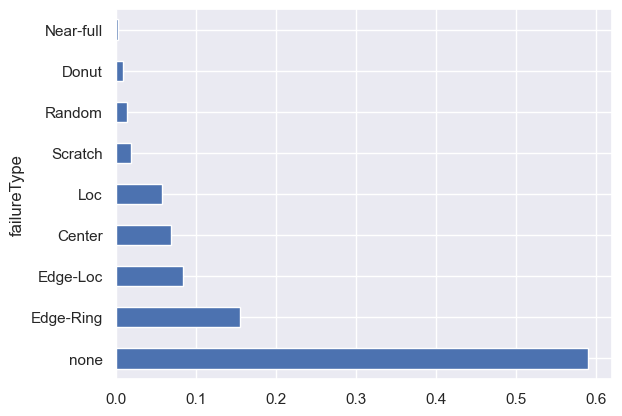

12450


,count,fraction
failureType,,
none,7346,0.590040
Edge-Ring,1936,0.155502
Edge-Loc,1038,0.083373
Center,859,0.068996
Loc,718,0.057671
Scratch,239,0.019197
Random,173,0.013896
Donut,111,0.008916
Near-full,30,0.002410


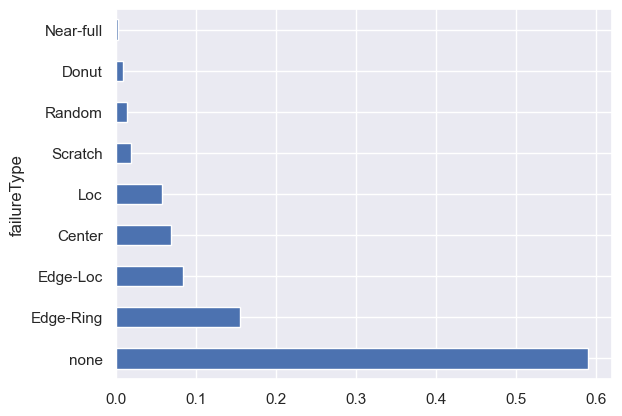

In [14]:
for series in (train_1_split, train_10_split, train_20_split, train_29_split, train_data, val_data):
    print(len(series))
    show_breakdown(series.failureType)

Saving the files is a bit tricky because the wafer maps are 2-dimensional, and they aren't the same sizes. Fortunately, we can use pickle files to save the data without having to worry about the shape of the wafer maps. We'll also use xz compression to greatly reduce the size of the files.

In [18]:
# save all splits from full training data to file
save_path = "../data/processed/WM811K"
os.makedirs(save_path, exist_ok=True)

# Save all splits from full training data to file
for split in (
    train_data,
    val_data,
    test_data,
    train_val_data,
    train_1_split,
    train_10_split,
    train_20_split,
    train_29_split,
):
    # Get the name of the split (create a string that is the same as the variable name)
    split_name = [k for k, v in locals().items() if v is split][0]
    # Save as a compressed pickle file using xz compression
    split.to_pickle(f"{save_path}/{split_name}.pkl.xz", compression="xz")

    # As a sanity check, read the data back in and ensure it is the same
    read_data = pd.read_pickle(f"{save_path}/{split_name}.pkl.xz")
    assert read_data.equals(split), f"{split_name} is not the same when read back in!"

## Misc: Plotting Wafer Maps

Some minor notes about plotting wafer maps here. Remember to resize wafer map arrays to be square, and always use nearest-neighbor interpolation when resizing. The wafer map should never be blurry! If you want your resized output to be an image, use `PIL`. If you want the resized output to still be an array, use `skimage` or `opencv` (I prefer the latter).

In [17]:
# Randomly select a single wafer map
wafer_map = train_data.waferMap.sample().iloc[0]

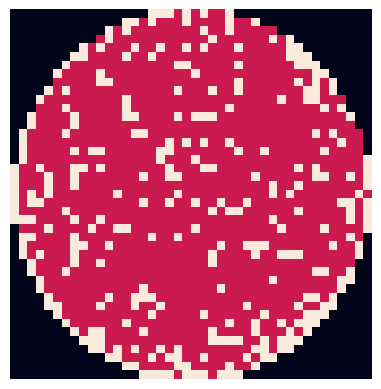

In [18]:
sns.set_theme(style="white", palette=None)

wafer = train_data.waferMap.sample().iloc[0]

# Naive way to plot wafer map without any resizing
plt.imshow(wafer)
plt.axis("off")
plt.show()

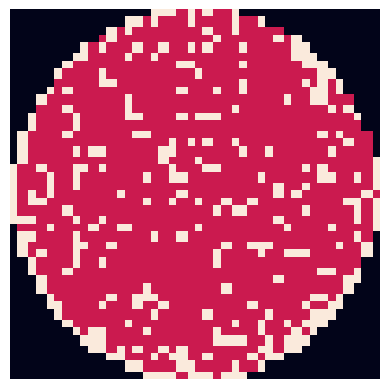

In [19]:
# Resize with output as image
img = Image.fromarray(wafer)
img = img.resize((100, 100), Image.NEAREST)
plt.imshow(img)
plt.axis("off")
plt.show()

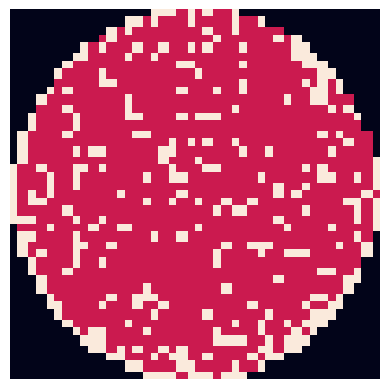

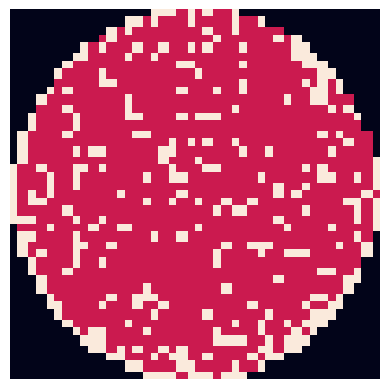

In [20]:
# Resize with output as array

# With PIL, you'd have to go from array -> image -> array
img = Image.fromarray(wafer)
img = img.resize((100, 100), Image.NEAREST)
img = np.array(img)
plt.imshow(img)
plt.axis("off")
plt.show()

# Or, use OpenCV which can resize an array directly
img = cv2.resize(wafer, (100, 100), interpolation=cv2.INTER_NEAREST_EXACT)
plt.imshow(img)
plt.axis("off")
plt.show()

You can also plot 3-channel images, but you can't directly plot 3-channel `torch` tensors because tensors have their channels as the first dimension; [matplotlib expects the channels to be the last dimension](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

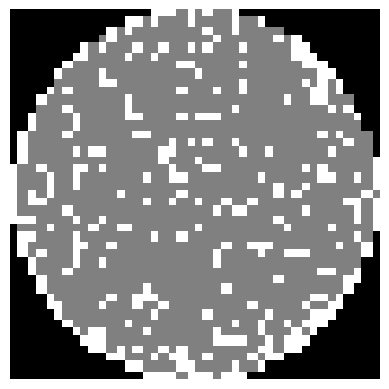

In [21]:
# From a 2D array to a 3D array directly
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
plt.imshow(rgb_img)
plt.axis("off")
plt.show()

For torch tensors, either permute the axes or plot a single channel.

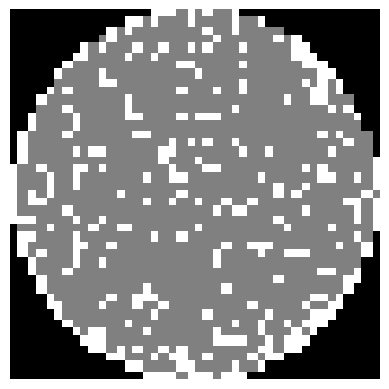

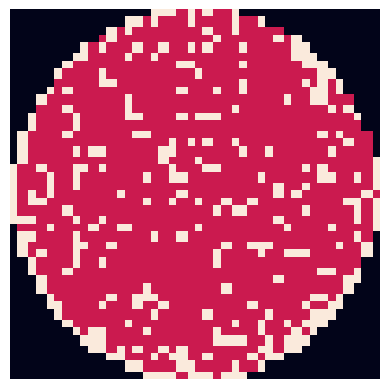

In [22]:
torchvision_transforms = T.Compose(
    [
        T.ToPILImage(),
        T.Resize((100, 100), interpolation=InterpolationMode.NEAREST),
        T.Grayscale(3),
        T.ToTensor(),
    ]
)

img_torch = torchvision_transforms(wafer)

# Either permute the dimensions
plt.imshow(img_torch.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Or, just plot one of the channels
plt.imshow(img_torch[0])
plt.axis("off")
plt.show()

## Going from Data to Vectors

### Part 1: Features from a Imagenet weights

Imagenet is a dataset of 14 million images with 1000 categories. It's a very popular dataset for computer vision tasks. The weights from a model trained on Imagenet can be used to extract features from images, and this is a reasonable practice for getting vector representations so long as your images are similar to the ones in Imagenet. The specific pretrained model we'll be using is a ResNet18. I prefer getting models from `timm` instead of `torchvision` because there are more models available, and the weights are actually a bit better. [The documentation for `timm` does an excellent job of explaining how to use models for feature extraction.](https://huggingface.co/docs/timm/feature_extraction)

#### Torchvision transforms

Recall that the wafer maps are 2D arrays. For use in pretrained neural nets, we need 3-channel tensors. We'll use `torchvision`'s transforms to do this:
- `ToPILImage`: Converts a NumPy array to a PIL image. This is necessary because most of `torchvision`'s transforms only work on PIL images.
- `Resize`: Resizes the image to a square of size 224x224. This is the size of the images in Imagenet. Remember to use nearest-neighbor interpolation!!
- `Grayscale(num_out_channels=3)`: Usually this is used to convert images to grayscale, but it can also be used to copy a single channel to all 3 channels. This is necessary because the pretrained model we're using has weights for 3 channel images (you could use `in_chans=1` with a `timm` model but you'd need to fine-tune the model afterwards).
- `ToTensor`: Converts the PIL image to a PyTorch tensor.


In [23]:
torchvision_transforms = T.Compose(
    [
        T.ToPILImage(),
        T.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        T.Grayscale(3),
        T.ToTensor(),
    ]
)

You could use a pretrained model to extract features from images one-by-one, but it is significantly faster to do this in batches. We'll use `torch.utils.data.DataLoader` to do this, so we'll first need our own custom dataset class, `WaferMapDataset`. All this will do is take in a dataframe and return the image and label for each row. The label won't actually be used for anything, but I've included it here for completeness.

In [24]:
from ssl_wafermap.utilities.data import WaferMapDataset


# Read in one of the splits to create a dataset
data_split = pd.read_pickle(f"{save_path}/train_20_split.pkl.xz")

# Create the dataset and dataloader
# Set shuffle=False since we want to preserve the order of the data!!
dataset = WaferMapDataset(
    X=data_split.waferMap, y=data_split.failureCode, transform=torchvision_transforms
)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=False)

Now we create out actual feature extractor using a pretrained ResNet18. I like using PyTorch Lightning over vanilla PyTorch but it doesn't really make a difference.

In [25]:
# Create a pl.LightningModule for a Resnet18 from timm with num_classes=0
# We only need to use this as a feature extractor, so just define a forward pass and predict_step

class ImageNetR18(pl.LightningModule):
    def __init__(self, num_classes=0):
        super().__init__()
        self.model = timm.create_model(
            "resnet18", pretrained=True, num_classes=num_classes
        )

    def forward(self, x):
        return self.model(x)

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        return self(x)

Now we can use this for feature extraction 😃

This should be pretty fast. The reason I've shared this as a Colab notebook is for GPU access. Try using GPU if possible. If you're using Colab, you can change the runtime type to GPU by going to `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU`.

In [26]:
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=False,
)
preds = trainer.predict(model=ImageNetR18(), dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [27]:
# preds is a list of tensors, so we need to concatenate them
preds = torch.cat(preds)

# To get these to numpy arrays, we can use .detach().cpu().numpy()
features = preds.detach().cpu().numpy()
features.shape  # (n_samples, 512)

(12449, 512)

Note that the order of the vectors is the same as the order in the dataframe. You could add each vector in a new column like  below, although it might be easier to do downstream analysis like UMAP, clustering, etc. on just the feature matrix itself.

In [28]:
vectors = [features[i] for i in range(len(features))]
data_split["imagenet"] = vectors
data_split

,waferMap,failureType,failureCode,imagenet
44059,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4,"[4.47257, 0.079800345, 1.3731602, 0.22698526, ..."
4524,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 128,...",none,8,"[1.435749, 0.07840235, 2.2960374, 0.9042954, 0..."
10870,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Scratch,7,"[2.5980442, 0.6401882, 0.59485227, 1.1455781, ..."
167,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 128,...",none,8,"[1.0258946, 0.10851015, 2.938215, 0.889692, 0...."
10180,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3,"[4.8291593, 0.115651384, 2.8041127, 0.08996949..."
...,...,...,...,...
7593,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ...",Edge-Ring,3,"[2.3039627, 0.05499196, 1.8007283, 0.27264607,..."
55462,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...",Edge-Loc,2,"[1.7743281, 0.097747736, 1.5793117, 0.15124905..."
45135,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...",Center,0,"[1.564244, 0.11866355, 1.5432862, 0.5698134, 0..."
20999,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3,"[5.824549, 0.053302262, 2.3346448, 0.0500424, ..."


### Part 2: Features from self-supervised pretraining

The models here are still a work in progress. I've got plenty of preliminary models trained already, but expect to see newer models in the next few weeks. The process of going from wafer map to vector will be nearly the same as with ImageNet weights. The only difference will be the model (i.e. `ImageNetResNet18` vs some other model).

### Part 3: SIFT features

Using SIFT will give you keypoints and descriptors for images. Each descriptor is a vector, and every keypoint has a descriptor associated with it. That means that using SIFT directly will give you a feature *matrix* for each image (the descriptors for all its keypoints) instead of a single feature vector.

There are many ways to go from a SIFT feature matrix to a single vector.

1. **Bag-of-visual-words (BoVW) with SIFT**: This involves clustering the SIFT descriptors into visual words and representing each image as a histogram of these visual words. This is a popular approach for image classification and retrieval tasks (which is kinda what we're after 👀)

2. **Fisher vectors with SIFT**: Fisher vectors are an extension of BoVW that take into account the spatial relationships between the visual words. In this approach, each SIFT descriptor is assigned to a set of visual words, and a Gaussian mixture model is trained to model the distribution of the descriptors within each visual word. The Fisher vector for an image is the concatenation of the mean, covariance, and derivative of the log-likelihood of the SIFT descriptors with respect to the GMM parameters.

3. **VLAD with SIFT**: VLAD (vector of locally aggregated descriptors) is another extension of BoVW that computes the residuals between each SIFT descriptor and its nearest visual word, and aggregates these residuals using a fixed-length vector. The resulting VLAD vector can be further processed using PCA or L2 normalization.

4. **Bag-of-features (BoF) with SIFT**: This approach is similar to BoVW, but uses a different feature descriptor (such as SURF or ORB) instead of SIFT. BoF can be simpler and faster than BoVW, but may not be as discriminative.

Below I have some code for the first method, BoVW. It's fairly simple to implement using just OpenCV, but it'll still take some time to run. On my personal desktop this took 6 minutes in total; Colab's CPU kinda sucks so it'll probably take longer.

Concretely, here's what we're doing:

- For each wafer map, we extract SIFT keypoints and descriptors.
  - Add the descriptors to a `BOWKMeansTrainer` object, which will be used to cluster the descriptors into visual words. This trainer object must be passed a number of visual words. The visual words are a set of representative feature vectors that are obtained by performing k-means clustering on the SIFT descriptors extracted from your images. Thus, the number of visual words represents the number of clusters that are created during the k-means clustering process. Each cluster corresponds to a visual word, which is a representative feature vector that is used to summarize the set of SIFT descriptors that belong to the cluster. The idea is that by representing the set of SIFT descriptors using a small number of visual words, we can reduce the dimensionality of the feature vectors and make them more computationally efficient to work with.
- Once we've added all the descriptors to the trainer, we can call `cluster()` to perform k-means clustering and obtain cluster centers; these cluster centers *are* the visual words that will be used to represent the images.
- Create a `BOWImgDescriptorExtractor` object, which will be used to extract the feature vectors for each image.
  - Set the vocabulary of the `BOWImgDescriptorExtractor` object to the visual words / cluster centers obtained from the `BOWKMeansTrainer`.
  - Specify the distance metric used for feature matching. This is the distance metric used to compare the SIFT descriptors extracted from the image with the visual words. The default is `cv2.NORM_L2`, which is the Euclidean distance.
- Loop through each wafer map again, extracting SIFT keypoints and descriptors for each.
  - Use the `BOWImgDescriptorExtractor` to extract the feature vector for each image. This feature vector is a histogram of the visual words. Let's say you used 100 visual words to build the vocabulary. Then, the histogram for each image will be a vector with 100 elements, each element representing the *frequency* of a visual word (cluster center) in the image. 

Let me know if you have any questions about this. I'm not an expert on SIFT so this is new to me too 😅 But basically we're using SIFT to extract keypoints and descriptors from each image, and then using k-means clustering to cluster the descriptors into visual words. We then use the visual words to build a histogram for each image by determining the frequency of each visual word in the image. This histogram can be used as a feature vector for the image, and it can be treated as a Euclidean vector.

Code below takes some inspiration from these, but I tried to keep it clean and self-contained in just OpenCV:
- https://github.com/Akhilesh64/Image-Classification-using-SIFT/blob/main/main.py
- https://liverungrow.medium.com/sift-bag-of-features-svm-for-classification-b5f775d8e55f

I might have to ask the professor and TAs if there's a better way to get SIFT feature vectors from keypoints and descriptors. Below we resize the wafer maps to square images by using OpenCV, and we take a look at what exactly the keypoints mean by drawing them onto a random wafer map. Notice that they're mostly on the "interesting" portions of the wafer map, the defects!

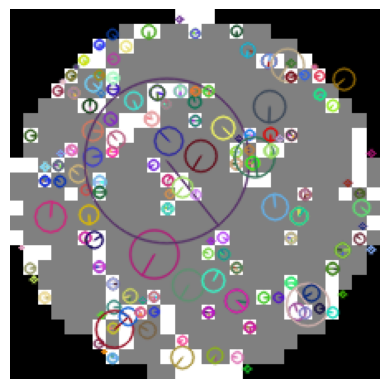

In [99]:
# Load images; resize to 224x224 to be consistent with image sizes used in the other methods
imgs = data_split.waferMap.apply(
    lambda x: cv2.resize(x, (224, 224), interpolation=cv2.INTER_NEAREST_EXACT)
)  # Use .sample(N) to only do this for N images

# Given a wafermap, compute SIFT keypoints and draw them on the image
def draw_sift_keypoints(wafermap):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(wafermap, None)
    img = cv2.drawKeypoints(
        wafermap, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    return img


wafer = imgs.sample(1).iloc[0]
img = draw_sift_keypoints(wafer)
plt.imshow(img)
plt.axis("off")
plt.show()

And now for the full SIFT BoVW feature extraction pipeline.

In [101]:
# Create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Create BOWKMeansTrainer object
bow_trainer = cv2.BOWKMeansTrainer(100) # number of visual words

# Extract SIFT features and add them to trainer
keyoints = []
descriptors = []
for img in tqdm(imgs):
    kp, des = sift.detectAndCompute(img, None)
    bow_trainer.add(des)
    # Store keypoints and descriptors for later use to avoid recomputing
    keyoints.append(kp)
    descriptors.append(des)

  0%|          | 0/12449 [00:00<?, ?it/s]

In [85]:
# Perform k-means clustering to obtain visual words (this takes a bit on 12k images)
voc = bow_trainer.cluster()

In [103]:
# Create BOWImgDescriptorExtractor object
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, cv2.BFMatcher(cv2.NORM_L2))

# Set vocabulary for extractor
bow_extractor.setVocabulary(voc)

# Extract bag of visual words histograms for images
features = []
for i, img in enumerate(tqdm(imgs)):
    bow_descriptor = bow_extractor.compute(img, keyoints[i])
    features.append(bow_descriptor)

# The resulting 'features' variable contains the bag of visual words histograms for each image
# This is a list of 2D arrays (each array/histogram is 1 x n_visual_words); use np.vstack
features = np.vstack(features)

# As before, we can use this to create a new column in our dataframe
sift_vectors = [features[i] for i in range(len(features))]
data_split["sift"] = sift_vectors
data_split

  0%|          | 0/12449 [00:00<?, ?it/s]

,waferMap,failureType,failureCode,imagenet,sift
44059,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4,"[4.47257, 0.079800345, 1.3731602, 0.22698526, ...","[0.0, 0.0, 0.010638298, 0.0, 0.021276595, 0.01..."
4524,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 128, 128,...",none,8,"[1.435749, 0.07840235, 2.2960374, 0.9042954, 0...","[0.0, 0.004032258, 0.004032258, 0.012096774, 0..."
10870,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Scratch,7,"[2.5980442, 0.6401882, 0.59485227, 1.1455781, ...","[0.0, 0.005934718, 0.0, 0.0, 0.0, 0.008902077,..."
167,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 128,...",none,8,"[1.0258946, 0.10851015, 2.938215, 0.889692, 0....","[0.0033670033, 0.013468013, 0.0, 0.0, 0.013468..."
10180,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3,"[4.8291593, 0.115651384, 2.8041127, 0.08996949...","[0.0, 0.0, 0.013043478, 0.0, 0.0, 0.004347826,..."
...,...,...,...,...,...
7593,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, ...",Edge-Ring,3,"[2.3039627, 0.05499196, 1.8007283, 0.27264607,...","[0.0, 0.0, 0.02, 0.016666668, 0.013333334, 0.0..."
55462,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...",Edge-Loc,2,"[1.7743281, 0.097747736, 1.5793117, 0.15124905...","[0.0, 0.0089552235, 0.017910447, 0.0089552235,..."
45135,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 128...",Center,0,"[1.564244, 0.11866355, 1.5432862, 0.5698134, 0...","[0.0, 0.0, 0.005181347, 0.005181347, 0.0207253..."
20999,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Ring,3,"[5.824549, 0.053302262, 2.3346448, 0.0500424, ...","[0.0, 0.005235602, 0.020942409, 0.005235602, 0..."


Above we used just OpenCV to extract SIFT features and then create a bag-of-visual-words. Below is another approach you could take that involves `sklearn`. Here, the visual words are defined as the unique tokens that appear in the set of feature descriptors. Each feature vector is represented as a histogram that counts the number of times each token appears in the descriptor, but then, the histogram is normalized using term frequency-inverse document frequency (TF-IDF). This approach seems to be more computationally expensive than the OpenCV approach, so I'd stick to the BoVW approach.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer

# Load images
imgs = data_split.waferMap.apply(
    lambda x: cv2.resize(x, (224, 224), interpolation=cv2.INTER_NEAREST_EXACT)
)

# Extract SIFT features
sift = cv2.xfeatures2d.SIFT_create()
descriptors = []
for img in imgs:
    kp, des = sift.detectAndCompute(img, None)
    descriptors.append(des)
descriptors = np.vstack(descriptors)

# Cluster descriptors
k = 100 # number of visual words
kmeans = KMeans(n_clusters=k)
kmeans.fit(descriptors)
visual_words = kmeans.cluster_centers_

# Create histograms of visual word counts
histograms = []
for des in descriptors:
    labels = kmeans.predict(des)
    histogram, _ = np.histogram(labels, bins=range(k+1))
    histograms.append(histogram)
histograms = np.vstack(histograms)

# Apply tf-idf weighting
transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
features = transformer.fit_transform(histograms)
features = features.toarray()

# The resulting 'features' variable contains the normalized feature vectors for each image